Early Spring Data Exploration 
========================

* Frame the problem and look at the big picture
* Get the data



In [23]:
# All of your imports here 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import os

In [24]:
# def new_date_features(data):
 ##   data['year'] = data['date'].dt.year
 #   data['month'] = data['date'].dt.month
  #  data['day'] = data['date'].dt.day
 #   return data

def drop_enso_columns(data):

    features_to_drop = [
        'global temperature anomalies',
        'Nino 1+2 SST',
        'Nino 1+2 SST Anomalies',
        'Nino 3 SST',
        'Nino 3 SST Anomalies',
        'Nino 3.4 SST',
        'Nino 3.4 SST Anomalies',
        'Nino 4 SST',
        'Nino 4 SST Anomalies',
        'TNI',
        'PNA',
        'OLR',
        'SOI',
        'Season (2-Month)',
        'Season (3-Month)',
        'Season (12-Month)',
        'ENSO Phase-Intensity'
    ]

    data = data.drop(columns=features_to_drop)

    return data



### **Pivoting The Data**

In [25]:
import pandas as pd

def pivot_enso():
    data = pd.read_csv('ENSO.csv', parse_dates=['date'])

    data = drop_enso_columns(data)
    dat = data.copy()
    dat['year'] = dat.date.dt.year
    dat['month'] = dat.date.dt.month
    
    # Apply year shifting if month is past March
    dat.loc[dat['month'] > 3, 'year'] += 1

    # Perform the pivot with both 'year' and 'month' before dropping
    dat_pivoted = dat.pivot(index='year', columns='month')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]

    # Now you can drop the 'month' column if needed (it was used for pivoting)
    dat_pivoted.reset_index(inplace=True)
    
    return dat_pivoted

def pivot_soil():
    data = pd.read_csv('soil.csv', parse_dates=['day'])

    dat = data.copy()
    dat['year'] = dat.day.dt.year
    dat['day_of_year'] = dat.day.dt.day_of_year
    dat['month'] = dat.day.dt.month
    
    # Apply year shifting if month is past March
    dat.loc[dat['month'] > 3, 'year'] += 1

    # Perform the pivot first, then remove 'month'
    dat_pivoted = dat.drop(columns=['day']).pivot(index='year', columns='day_of_year')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]
    
    return dat_pivoted

def pivot_weather():
    data = pd.read_csv('weather.csv', parse_dates=['date'])

    dat = data.copy()
    dat['year'] = dat.date.dt.year
    dat['day_of_year'] = dat.date.dt.day_of_year
    dat['month'] = dat.date.dt.month

    # Apply year shifting if month is past March
    dat.loc[dat['month'] > 3, 'year'] += 1

    # Perform the pivot first, then remove 'month'
    dat_pivoted = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]

    return dat_pivoted

#### **Merging The Data**

In [26]:
csv_files = [
    'early_spring.csv',
    'phil_pred.csv',
    'soil.csv',
    'weather.csv',
    'ENSO.csv'
]

def pivot_files():
    enso_pivoted = pivot_enso()
    soil_pivoted = pivot_soil()
    weather_pivoted = pivot_weather()

    return enso_pivoted, soil_pivoted, weather_pivoted

def process_file(df):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    elif 'day' in df.columns:
        df['day'] = pd.to_datetime(df['day'])
        df.rename(columns={'day': 'date'}, inplace=True)
    elif 'year' in df.columns:
        df['year'] = pd.to_datetime(df['year'], format='%Y')
        df.rename(columns={'year': 'date'}, inplace=True)
    return df

output_file = 'combined_data.csv'
combined_data = None

enso_pivoted, soil_pivoted, weather_pivoted = pivot_files()
phil_pred = pd.read_csv('phil_pred.csv')
# enso_pivoted = process_file(enso_pivoted)
# soil_pivoted = process_file(soil_pivoted)
# weather_pivoted = process_file(weather_pivoted)
# phil_pred = process_file(phil_pred)

datasets = [enso_pivoted, soil_pivoted, weather_pivoted, phil_pred]

for df in datasets:
    if combined_data is None:
        combined_data = df
    else:
        combined_data = pd.merge(combined_data, df, how='outer', on='year')
        print(f"Processed {df.shape[1]} columns from {df.shape[0]} rows")

combined_data = combined_data.sort_values(by='year')

combined_data.to_csv(output_file, index=False)

print("\nFirst 5 rows of sorted merged data:")
print(combined_data.head())
print("\nShape of sorted merged data:", combined_data.shape)
print("\nColumns in sorted merged data:")
print(combined_data.columns.tolist())
print("\nMerge and sorting completed. Combined data saved to", output_file)

Processed 392 columns from 70 rows
Processed 392 columns from 70 rows
Processed 2 columns from 70 rows

First 5 rows of sorted merged data:
   year     date_1     date_2     date_3     date_4     date_5     date_6  \
0  1947        NaT        NaT        NaT        NaT        NaT        NaT   
1  1948        NaT        NaT        NaT        NaT        NaT        NaT   
2  1949        NaT        NaT        NaT        NaT        NaT        NaT   
3  1950 1950-01-01 1950-02-01 1950-03-01        NaT        NaT        NaT   
4  1951 1951-01-01 1951-02-01 1951-03-01 1950-04-01 1950-05-01 1950-06-01   

      date_7     date_8     date_9    date_10    date_11    date_12  MEI.v2_1  \
0        NaT        NaT        NaT        NaT        NaT        NaT       NaN   
1        NaT        NaT        NaT        NaT        NaT        NaT       NaN   
2        NaT        NaT        NaT        NaT        NaT        NaT       NaN   
3        NaT        NaT        NaT        NaT        NaT        NaT      

# Frame the Problem and Look at the Big Picture 


1. **Define the objective in business terms:** We want to predict early spring for Groundhog Day (I think right?). We want to be able to estimate if there will be an early spring based on weather and soil data available before April 1st. Being able to predict this accurately can lead to significant financial gains.

2. **How will your solution be used?** It will be used to make a prediction before April 1st each year. The prediction will be based on daily local weather and soil data collected up to that point. This information will be used to make business decisions that can lead to increased profits if the prediction is correct.

3. **What is the current solution?** Currently, there might be traditional methods or less data-driven approaches to predicting early spring. Our solution aims to improve upon these by incorporating more data and using machine learning techniques.

4. **How should you frame this problem?** <mark>This will be a supervised problem where we are predicting whether there will be an early spring or not. We will want this to be a system that can adapt to climate changes over time. Since it's based on weather data, it's unlikely to be gamed or manipulated.</mark> 

5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Since we are When predicting early spring, both small and large mistakes are equally important up to a point. MAE (Mean Absolute Error) works well because it measures all mistakes the same way.</mark>

6. **What would be the minimum performance needed to reach the business objective?** The prediction accuracy should be significantly better than random guessing (50%) to be profitable. Given the profit/loss percentages, an accuracy above 65% would start to be profitable.

7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools and techniques from other binary classification problems in weather prediction or agricultural forecasting. Time series analysis tools will also be valuable given the nature of the data.</mark> 

8. **Is human expertise available?** idk.

9. **How would you solve the problem manually?** <mark>Collect data and compare it against our collected data if it shows similarities with the temperatures and what nought then we can make a educated guess whether it will be a earle spring.</mark>

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 
    - The local data collected daily is reliable and consistent over the years.
    - Climate change isn't dramatically altering the patterns year over year.
    - The 5-day period before April 1st is the most critical for prediction.


# Get the Data 

1. **List the data you need and how much you need:**
    - Historical weather data (temperature, precipitation, snowfall)
    - Soil temperature and moisture data
    - Early spring occurrence data
    - Groundhog Day predictions (if available)

2. **Find and document where you can get that data:**
    
    - N/A right now

3. **Get access authorizations**: Most of this data should be publicly available, but some soil data might require permission from agricultural departments.

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloaded early_spring.csv, phil_pred.csv, soil.csv, and weather.csv files
    - These files contain the necessary historical data for our analysis

6. **Convert the data to a format you can easily manipulate**:
   - Data is provided in CSV files, which are easy to use with pandas
   - We've already merged the data into a single combined_data.csv file for easier manipulation

7. **Ensure sensitive information is deleted or protected**: The data appears to be anonymized and doesn't contain sensitive information.

8. **Check the size and type of data (time series, geographical, …)**: <mark>TODO</mark>: Report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features, the number of samples, and any special considerations about the features such as:
   1. Is it a time series? (Yes, the data is time-based with daily measurements)
   2. Are any of the features not available for the business problem? (We need to ensure we're only using data available before April 1st for predictions)
   3. Which feature(s) will be used as the target/label for the business problem? (The 'early_spring' column from early_spring.csv is likely our target variable)
   4. Should any of the features be stratified during the train/test split to avoid sampling biases? (We might want to stratify by year to ensure we have a good distribution of early spring and non-early spring years in both train and test sets)


#### **Load The Data**

In [27]:
data = pd.read_csv('combined_data.csv') 
data

,year,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,date_10,date_11,date_12,MEI.v2_1,MEI.v2_2,MEI.v2_3,MEI.v2_4,MEI.v2_5,MEI.v2_6,MEI.v2_7,MEI.v2_8,MEI.v2_9,MEI.v2_10,MEI.v2_11,MEI.v2_12,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean_soil_temp_18,mean_soil_temp_19,mean_soil_temp_20,mean_soil_temp_21,mean_soil_temp_22,mean_soil_temp_23,mean_soil_temp_24,mean_soil_temp_25,mean_soil_temp_26,mean_soil_temp_27,mean_soil_temp_28,mean_soil_temp_29,mean_soil_temp_30,mean_soil_temp_31,mean_soil_temp_32,mean_soil_temp_33,mean_soil_temp_34,mean_soil_temp_35,mean_soil_temp_36,mean_soil_temp_37,mean_soil_temp_38,mean_soil_temp_39,mean_soil_temp_40,mean_soil_temp_41,mean_soil_temp_42,mean_soil_temp_43,mean_soil_temp_44,mean_soil_temp_45,mean_soil_temp_46,mean_soil_temp_47,mean_soil_temp_48,mean_soil_temp_49,mean_soil_temp_50,mean_soil_temp_51,mean_soil_temp_52,mean_soil_temp_53,mean_soil_temp_54,mean_soil_temp_55,mean_soil_temp_56,mean_soil_moisture_1,mean_soil_moisture_2,mean_soil_moisture_3,mean_soil_moisture_4,mean_soil_moisture_5,mean_soil_moisture_6,mean_soil_moisture_7,mean_soil_moisture_8,mean_soil_moisture_9,mean_soil_moisture_10,mean_soil_moisture_11,mean_soil_moisture_12,mean_soil_moisture_13,mean_soil_moisture_14,mean_soil_moisture_15,mean_soil_moisture_16,mean_soil_moisture_17,mean_soil_moisture_18,mean_soil_moisture_19,mean_soil_moisture_20,mean_soil_moisture_21,mean_soil_moisture_22,mean_soil_moisture_23,mean_soil_moisture_24,mean_soil_moisture_25,mean_soil_moisture_26,mean_soil_moisture_27,mean_soil_moisture_28,mean_soil_moisture_29,mean_soil_moisture_30,mean_soil_moisture_31,mean_soil_moisture_32,mean_soil_moisture_33,mean_soil_moisture_34,mean_soil_moisture_35,mean_soil_moisture_36,mean_soil_moisture_37,mean_soil_moisture_38,mean_soil_moisture_39,mean_soil_moisture_40,mean_soil_moisture_41,mean_soil_moisture_42,mean_soil_moisture_43,mean_soil_moisture_44,mean_soil_moisture_45,mean_soil_moisture_46,mean_soil_moisture_47,mean_soil_moisture_48,mean_soil_moisture_49,mean_soil_moisture_50,mean_soil_moisture_51,mean_soil_moisture_52,mean_soil_moisture_53,mean_soil_moisture_54,mean_soil_moisture_55,mean_soil_moisture_56,min_soil_temp_1,min_soil_temp_2,min_soil_temp_3,min_soil_temp_4,min_soil_temp_5,min_soil_temp_6,min_soil_temp_7,min_soil_temp_8,min_soil_temp_9,min_soil_temp_10,min_soil_temp_11,min_soil_temp_12,min_soil_temp_13,min_soil_temp_14,min_soil_temp_15,min_soil_temp_16,min_soil_temp_17,min_soil_temp_18,min_soil_temp_19,min_soil_temp_20,min_soil_temp_21,min_soil_temp_22,min_soil_temp_23,min_soil_temp_24,min_soil_temp_25,min_soil_temp_26,min_soil_temp_27,min_soil_temp_28,min_soil_temp_29,min_soil_temp_30,min_soil_temp_31,min_soil_temp_32,min_soil_temp_33,min_soil_temp_34,min_soil_temp_35,min_soil_temp_36,min_soil_temp_37,min_soil_temp_38,min_soil_temp_39,min_soil_temp_40,min_soil_temp_41,min_soil_temp_42,min_soil_temp_43,min_soil_temp_44,min_soil_temp_45,min_soil_temp_46,min_soil_temp_47,min_soil_temp_48,min_soil_temp_49,min_soil_temp_50,min_soil_temp_51,min_soil_temp_52,min_soil_temp_53,min_soil_temp_54,min_soil_temp_55,min_soil_temp_56,min_soil_moisture_1,min_soil_moisture_2,min_soil_moisture_3,min_soil_moisture_4,min_soil_moisture_5,min_soil_moisture_6,min_soil_moisture_7,min_soil_moisture_8,min_soil_moisture_9,min_soil_moisture_10,min_soil_moisture_11,min_soil_moisture_12,min_soil_moisture_13,min_soil_moisture_14,min_soil_moisture_15,min_soil_moisture_16,min_soil_moisture_17,min_soil_moisture_18,min_soil_moisture_19,min_soil_moisture_20,min_soil_moisture_21,min_soil_moisture_22,min_soil_moisture_23,min_soil_moisture_24,min_soil_moisture_25,min_soil_moisture_26,min_soil_moisture_2

#### **Looking At The Features**

In [28]:
data.shape

(78, 822)

#### **Removing Columns With Missing Values/ Or Useless Columns**

In [29]:
empty_columns = data.columns[data.isna().all()].tolist() # Get columns with all NaN values
for column in empty_columns:
    print(f"Column {column} is empty. Dropping it.")
    data.drop(column, axis=1, inplace=True)

In [30]:
data = data.drop([col for col in data.columns if col.startswith('month')], axis=1) #  Drop month columns
data.shape  


(78, 710)

#### **Percentages Of Missing Values**

In [31]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year             0.000000
date_1           5.128205
date_2           5.128205
date_3           5.128205
date_4           5.128205
                  ...    
snowdepth_53    10.256410
snowdepth_54    10.256410
snowdepth_55    10.256410
snowdepth_56    10.256410
prediction      10.256410
Length: 710, dtype: float64


In [32]:
pd.set_option('display.max_columns', None)

data.head()

,year,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,date_10,date_11,date_12,MEI.v2_1,MEI.v2_2,MEI.v2_3,MEI.v2_4,MEI.v2_5,MEI.v2_6,MEI.v2_7,MEI.v2_8,MEI.v2_9,MEI.v2_10,MEI.v2_11,MEI.v2_12,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean_soil_temp_18,mean_soil_temp_19,mean_soil_temp_20,mean_soil_temp_21,mean_soil_temp_22,mean_soil_temp_23,mean_soil_temp_24,mean_soil_temp_25,mean_soil_temp_26,mean_soil_temp_27,mean_soil_temp_28,mean_soil_temp_29,mean_soil_temp_30,mean_soil_temp_31,mean_soil_temp_32,mean_soil_temp_33,mean_soil_temp_34,mean_soil_temp_35,mean_soil_temp_36,mean_soil_temp_37,mean_soil_temp_38,mean_soil_temp_39,mean_soil_temp_40,mean_soil_temp_41,mean_soil_temp_42,mean_soil_temp_43,mean_soil_temp_44,mean_soil_temp_45,mean_soil_temp_46,mean_soil_temp_47,mean_soil_temp_48,mean_soil_temp_49,mean_soil_temp_50,mean_soil_temp_51,mean_soil_temp_52,mean_soil_temp_53,mean_soil_temp_54,mean_soil_temp_55,mean_soil_temp_56,mean_soil_moisture_1,mean_soil_moisture_2,mean_soil_moisture_3,mean_soil_moisture_4,mean_soil_moisture_5,mean_soil_moisture_6,mean_soil_moisture_7,mean_soil_moisture_8,mean_soil_moisture_9,mean_soil_moisture_10,mean_soil_moisture_11,mean_soil_moisture_12,mean_soil_moisture_13,mean_soil_moisture_14,mean_soil_moisture_15,mean_soil_moisture_16,mean_soil_moisture_17,mean_soil_moisture_18,mean_soil_moisture_19,mean_soil_moisture_20,mean_soil_moisture_21,mean_soil_moisture_22,mean_soil_moisture_23,mean_soil_moisture_24,mean_soil_moisture_25,mean_soil_moisture_26,mean_soil_moisture_27,mean_soil_moisture_28,mean_soil_moisture_29,mean_soil_moisture_30,mean_soil_moisture_31,mean_soil_moisture_32,mean_soil_moisture_33,mean_soil_moisture_34,mean_soil_moisture_35,mean_soil_moisture_36,mean_soil_moisture_37,mean_soil_moisture_38,mean_soil_moisture_39,mean_soil_moisture_40,mean_soil_moisture_41,mean_soil_moisture_42,mean_soil_moisture_43,mean_soil_moisture_44,mean_soil_moisture_45,mean_soil_moisture_46,mean_soil_moisture_47,mean_soil_moisture_48,mean_soil_moisture_49,mean_soil_moisture_50,mean_soil_moisture_51,mean_soil_moisture_52,mean_soil_moisture_53,mean_soil_moisture_54,mean_soil_moisture_55,mean_soil_moisture_56,min_soil_temp_1,min_soil_temp_2,min_soil_temp_3,min_soil_temp_4,min_soil_temp_5,min_soil_temp_6,min_soil_temp_7,min_soil_temp_8,min_soil_temp_9,min_soil_temp_10,min_soil_temp_11,min_soil_temp_12,min_soil_temp_13,min_soil_temp_14,min_soil_temp_15,min_soil_temp_16,min_soil_temp_17,min_soil_temp_18,min_soil_temp_19,min_soil_temp_20,min_soil_temp_21,min_soil_temp_22,min_soil_temp_23,min_soil_temp_24,min_soil_temp_25,min_soil_temp_26,min_soil_temp_27,min_soil_temp_28,min_soil_temp_29,min_soil_temp_30,min_soil_temp_31,min_soil_temp_32,min_soil_temp_33,min_soil_temp_34,min_soil_temp_35,min_soil_temp_36,min_soil_temp_37,min_soil_temp_38,min_soil_temp_39,min_soil_temp_40,min_soil_temp_41,min_soil_temp_42,min_soil_temp_43,min_soil_temp_44,min_soil_temp_45,min_soil_temp_46,min_soil_temp_47,min_soil_temp_48,min_soil_temp_49,min_soil_temp_50,min_soil_temp_51,min_soil_temp_52,min_soil_temp_53,min_soil_temp_54,min_soil_temp_55,min_soil_temp_56,min_soil_moisture_1,min_soil_moisture_2,min_soil_moisture_3,min_soil_moisture_4,min_soil_moisture_5,min_soil_moisture_6,min_soil_moisture_7,min_soil_moisture_8,min_soil_moisture_9,min_soil_moisture_10,min_soil_moisture_11,min_soil_moisture_12,min_soil_moisture_13,min_soil_moisture_14,min_soil_moisture_15,min_soil_moisture_16,min_soil_moisture_17,min_soil_moisture_18,min_soil_moisture_19,min_soil_moisture_20,min_soil_moisture_21,min_soil_moisture_22,min_soil_moisture_23,min_soil_moisture_24,min_soil_moisture_25,min_soil_moisture_26,min_soil_moisture_2

#### **Shifted NaN Values**

In [33]:
# Shift NaN values downwards for every column and forward fill
data = data.apply(lambda col: col.shift().ffill())


# Optionally, replace any remaining NaNs with a specific value (e.g., 0):
data = data.fillna(0)  # This will replace any remaining NaNs with 0
data.head()


,year,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,date_10,date_11,date_12,MEI.v2_1,MEI.v2_2,MEI.v2_3,MEI.v2_4,MEI.v2_5,MEI.v2_6,MEI.v2_7,MEI.v2_8,MEI.v2_9,MEI.v2_10,MEI.v2_11,MEI.v2_12,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean_soil_temp_18,mean_soil_temp_19,mean_soil_temp_20,mean_soil_temp_21,mean_soil_temp_22,mean_soil_temp_23,mean_soil_temp_24,mean_soil_temp_25,mean_soil_temp_26,mean_soil_temp_27,mean_soil_temp_28,mean_soil_temp_29,mean_soil_temp_30,mean_soil_temp_31,mean_soil_temp_32,mean_soil_temp_33,mean_soil_temp_34,mean_soil_temp_35,mean_soil_temp_36,mean_soil_temp_37,mean_soil_temp_38,mean_soil_temp_39,mean_soil_temp_40,mean_soil_temp_41,mean_soil_temp_42,mean_soil_temp_43,mean_soil_temp_44,mean_soil_temp_45,mean_soil_temp_46,mean_soil_temp_47,mean_soil_temp_48,mean_soil_temp_49,mean_soil_temp_50,mean_soil_temp_51,mean_soil_temp_52,mean_soil_temp_53,mean_soil_temp_54,mean_soil_temp_55,mean_soil_temp_56,mean_soil_moisture_1,mean_soil_moisture_2,mean_soil_moisture_3,mean_soil_moisture_4,mean_soil_moisture_5,mean_soil_moisture_6,mean_soil_moisture_7,mean_soil_moisture_8,mean_soil_moisture_9,mean_soil_moisture_10,mean_soil_moisture_11,mean_soil_moisture_12,mean_soil_moisture_13,mean_soil_moisture_14,mean_soil_moisture_15,mean_soil_moisture_16,mean_soil_moisture_17,mean_soil_moisture_18,mean_soil_moisture_19,mean_soil_moisture_20,mean_soil_moisture_21,mean_soil_moisture_22,mean_soil_moisture_23,mean_soil_moisture_24,mean_soil_moisture_25,mean_soil_moisture_26,mean_soil_moisture_27,mean_soil_moisture_28,mean_soil_moisture_29,mean_soil_moisture_30,mean_soil_moisture_31,mean_soil_moisture_32,mean_soil_moisture_33,mean_soil_moisture_34,mean_soil_moisture_35,mean_soil_moisture_36,mean_soil_moisture_37,mean_soil_moisture_38,mean_soil_moisture_39,mean_soil_moisture_40,mean_soil_moisture_41,mean_soil_moisture_42,mean_soil_moisture_43,mean_soil_moisture_44,mean_soil_moisture_45,mean_soil_moisture_46,mean_soil_moisture_47,mean_soil_moisture_48,mean_soil_moisture_49,mean_soil_moisture_50,mean_soil_moisture_51,mean_soil_moisture_52,mean_soil_moisture_53,mean_soil_moisture_54,mean_soil_moisture_55,mean_soil_moisture_56,min_soil_temp_1,min_soil_temp_2,min_soil_temp_3,min_soil_temp_4,min_soil_temp_5,min_soil_temp_6,min_soil_temp_7,min_soil_temp_8,min_soil_temp_9,min_soil_temp_10,min_soil_temp_11,min_soil_temp_12,min_soil_temp_13,min_soil_temp_14,min_soil_temp_15,min_soil_temp_16,min_soil_temp_17,min_soil_temp_18,min_soil_temp_19,min_soil_temp_20,min_soil_temp_21,min_soil_temp_22,min_soil_temp_23,min_soil_temp_24,min_soil_temp_25,min_soil_temp_26,min_soil_temp_27,min_soil_temp_28,min_soil_temp_29,min_soil_temp_30,min_soil_temp_31,min_soil_temp_32,min_soil_temp_33,min_soil_temp_34,min_soil_temp_35,min_soil_temp_36,min_soil_temp_37,min_soil_temp_38,min_soil_temp_39,min_soil_temp_40,min_soil_temp_41,min_soil_temp_42,min_soil_temp_43,min_soil_temp_44,min_soil_temp_45,min_soil_temp_46,min_soil_temp_47,min_soil_temp_48,min_soil_temp_49,min_soil_temp_50,min_soil_temp_51,min_soil_temp_52,min_soil_temp_53,min_soil_temp_54,min_soil_temp_55,min_soil_temp_56,min_soil_moisture_1,min_soil_moisture_2,min_soil_moisture_3,min_soil_moisture_4,min_soil_moisture_5,min_soil_moisture_6,min_soil_moisture_7,min_soil_moisture_8,min_soil_moisture_9,min_soil_moisture_10,min_soil_moisture_11,min_soil_moisture_12,min_soil_moisture_13,min_soil_moisture_14,min_soil_moisture_15,min_soil_moisture_16,min_soil_moisture_17,min_soil_moisture_18,min_soil_moisture_19,min_soil_moisture_20,min_soil_moisture_21,min_soil_moisture_22,min_soil_moisture_23,min_soil_moisture_24,min_soil_moisture_25,min_soil_moisture_26,min_soil_moisture_2

#### **Correlation Heatmap**

- From what we can see the correlation matrix reveals strong relationships within soil temperature measures and within soil moisture measures, but weaker connections between temperature and moisture. For example, there's little correlation between soil conditions and time features like year, month, or day.
- This basically means that soil temperature and moisture levels are generally consistent on their own, but they don't always change in sync with each other and don't follow clear seasonal or time-based patterns

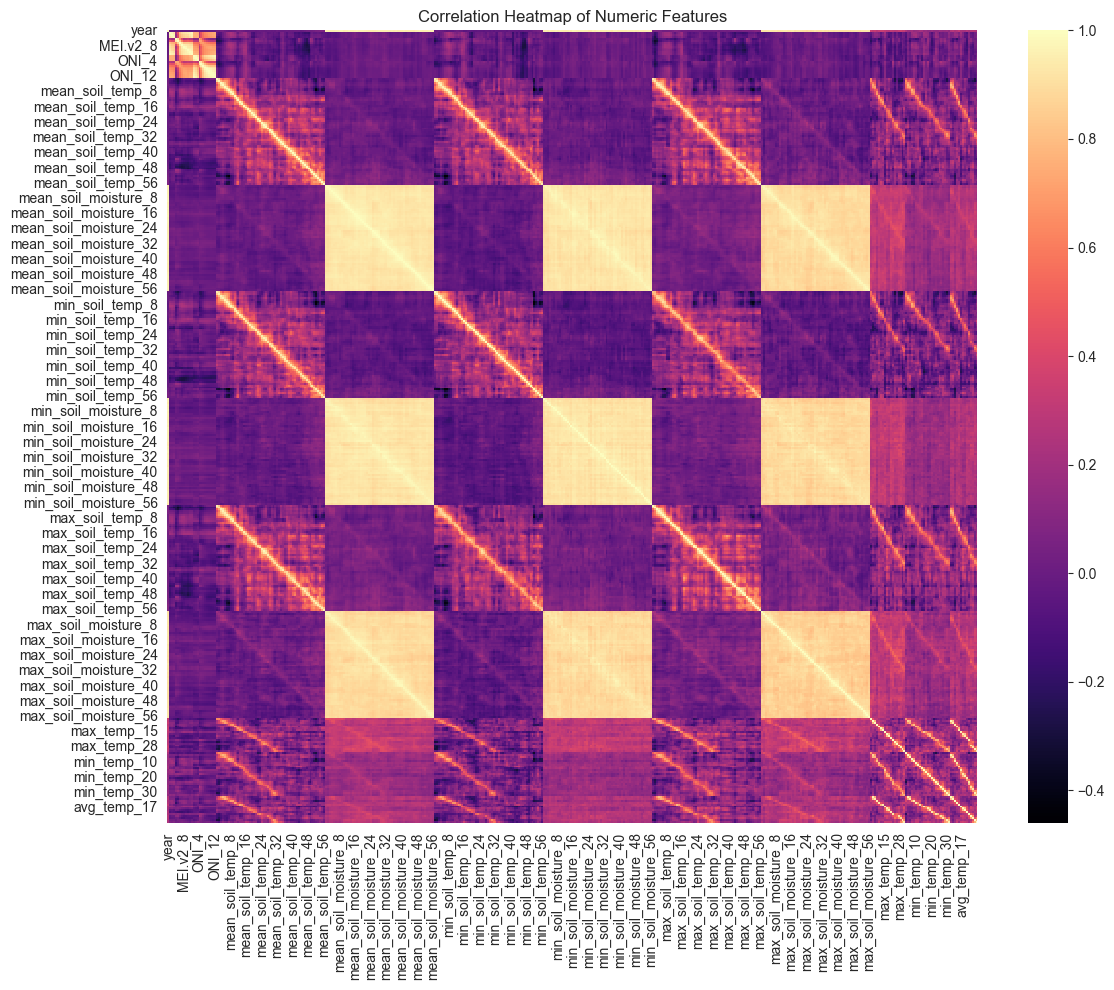

In [34]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()

The graph shows soil temperatures from five locations, ranging from -10°C to +12°C over about 80 samples. The lines track closely together, indicating similar temperature changes. Notable spikes occur around samples 5, 50, and 75, with a drop between samples 65 and 70. Overall, soil temperatures are mostly consistent across the area, with minor differences between locations.


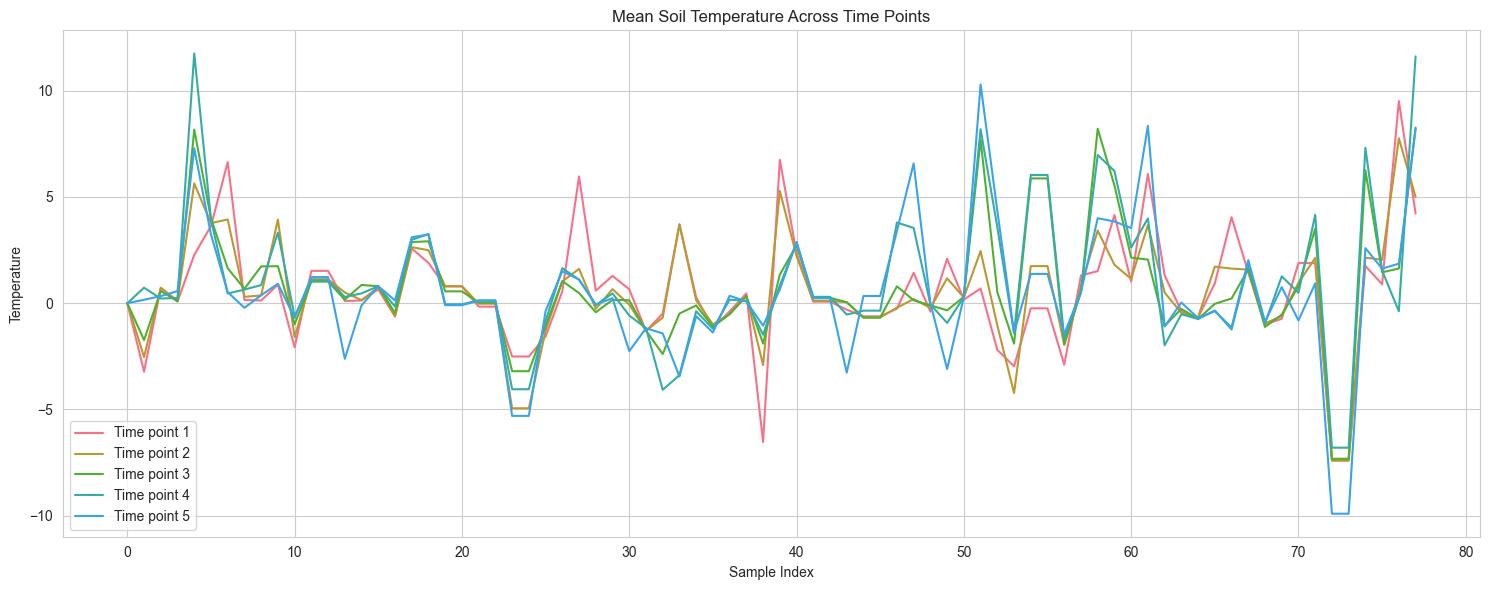

In [35]:
plt.figure(figsize=(15, 6))
soil_temp_cols = [col for col in data.columns if 'soil_temp' in col and 'mean' in col][:5]  # First 5 time points
for col in soil_temp_cols:
    plt.plot(data.index, data[col], label=f'Time point {col.split("_")[-1]}')
plt.title('Mean Soil Temperature Across Time Points')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()


This boxplot displays soil moisture levels measured at five different times, ranging from about 0.44 to 0.51. The median moisture level (indicated by the red lines) is stable at around 0.47 across all time points. The similar sizes of the boxes and whiskers suggest that soil moisture is fairly consistent with little variation between measurements.


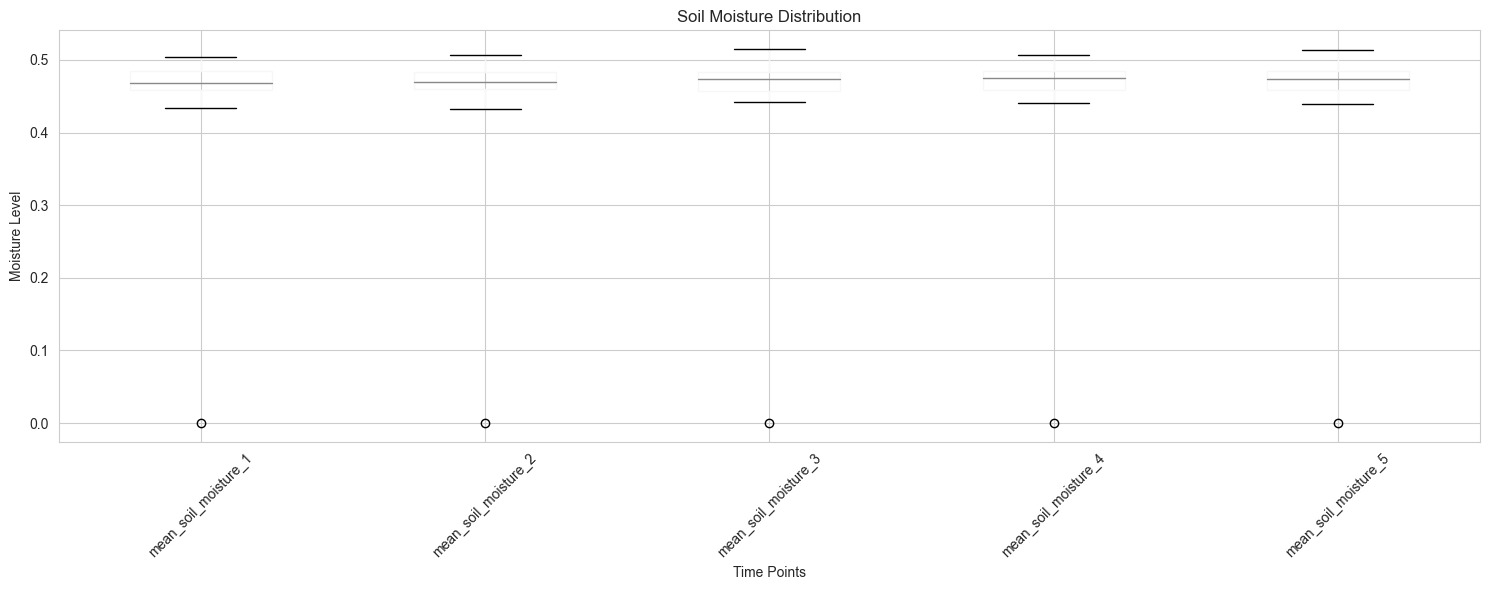

In [36]:
plt.figure(figsize=(15, 6))
moisture_cols = [col for col in data.columns if 'soil_moisture' in col and 'mean' in col][:5]
data[moisture_cols].boxplot()
plt.title('Soil Moisture Distribution')
plt.xlabel('Time Points')
plt.ylabel('Moisture Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This scatter plot shows the relationship between soil temperature (x-axis: -7.5°C to 10°C) and soil moisture (y-axis: 0.44 to 0.51), with color intensity indicating data density. Most points cluster around 0°C and 0.47-0.49 moisture levels, but there’s no strong linear relationship, suggesting the two variables are mostly independent.

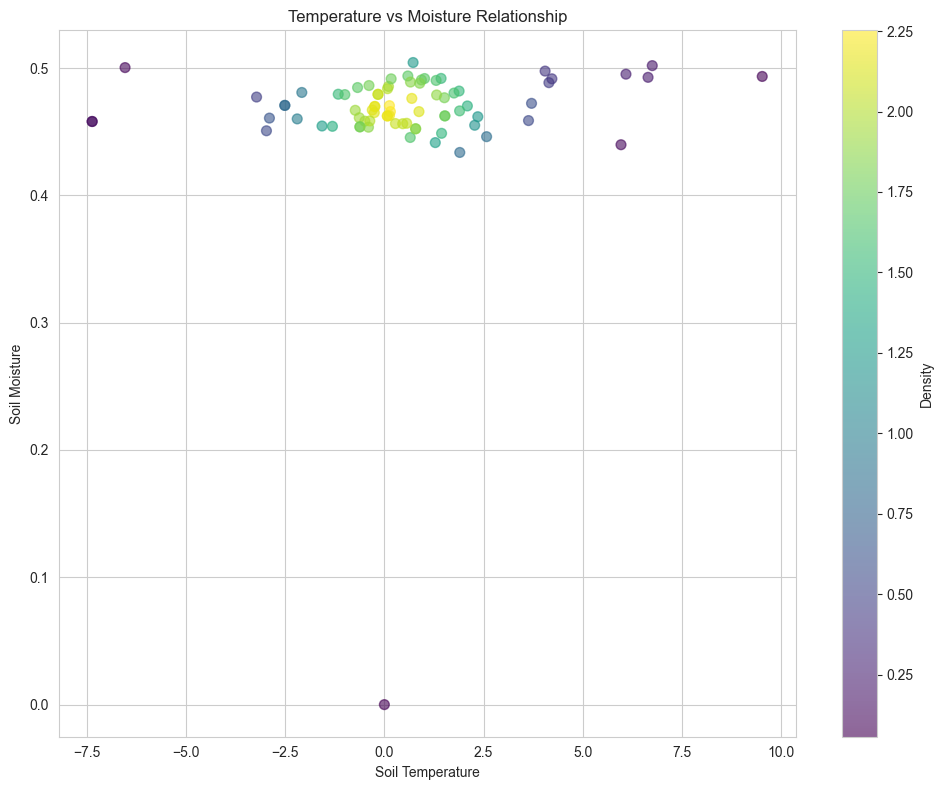

In [37]:
plt.figure(figsize=(10, 8))
if soil_temp_cols and moisture_cols:
    x = data[soil_temp_cols[0]]  # First time point
    y = data[moisture_cols[0]]
    
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Create density scatter plot
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Density')
    
plt.title('Temperature vs Moisture Relationship')
plt.xlabel('Soil Temperature')
plt.ylabel('Soil Moisture')
plt.tight_layout()
plt.show()


The graph displays soil temperature changes from 1950 to 2020. The red line shows the average temperature, while the pink area shows how much the temperature can vary. You can see spikes in temperature around 1950, 1990, and 2015. Most of the time, the temperature stayed between -2.5°C and 5°C, but it dropped sharply to -7.5°C close to 2020.


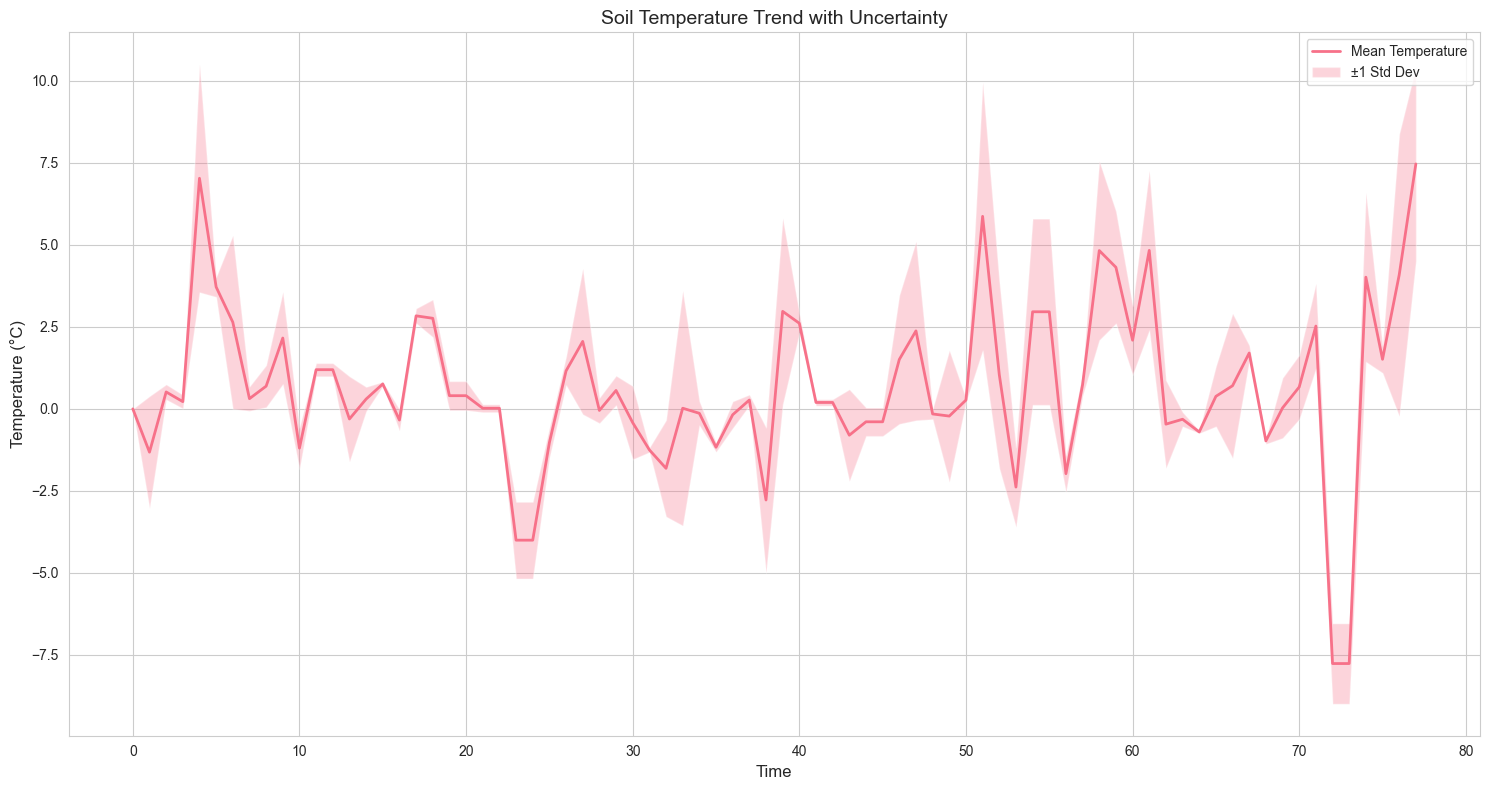

In [38]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Calculate mean and std for temperature columns
temp_mean = data[soil_temp_cols].mean(axis=1)
temp_std = data[soil_temp_cols].std(axis=1)

plt.plot(data.index, temp_mean, label='Mean Temperature', linewidth=2)
plt.fill_between(data.index, 
                 temp_mean - temp_std, 
                 temp_mean + temp_std, 
                 alpha=0.3,
                 label='±1 Std Dev')
plt.title('Soil Temperature Trend with Uncertainty', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

This graph shows the relationship between soil temperature (x-axis) and soil moisture (y-axis), with histograms on the sides showing how often each value appears. The red line shows a slight positive trend, meaning that as temperature increases, moisture tends to increase a little too. However, the points are scattered, so the relationship isn't strong. The histograms indicate that most temperatures are around 0°C, while moisture levels are mostly between 0.46 and 0.49.

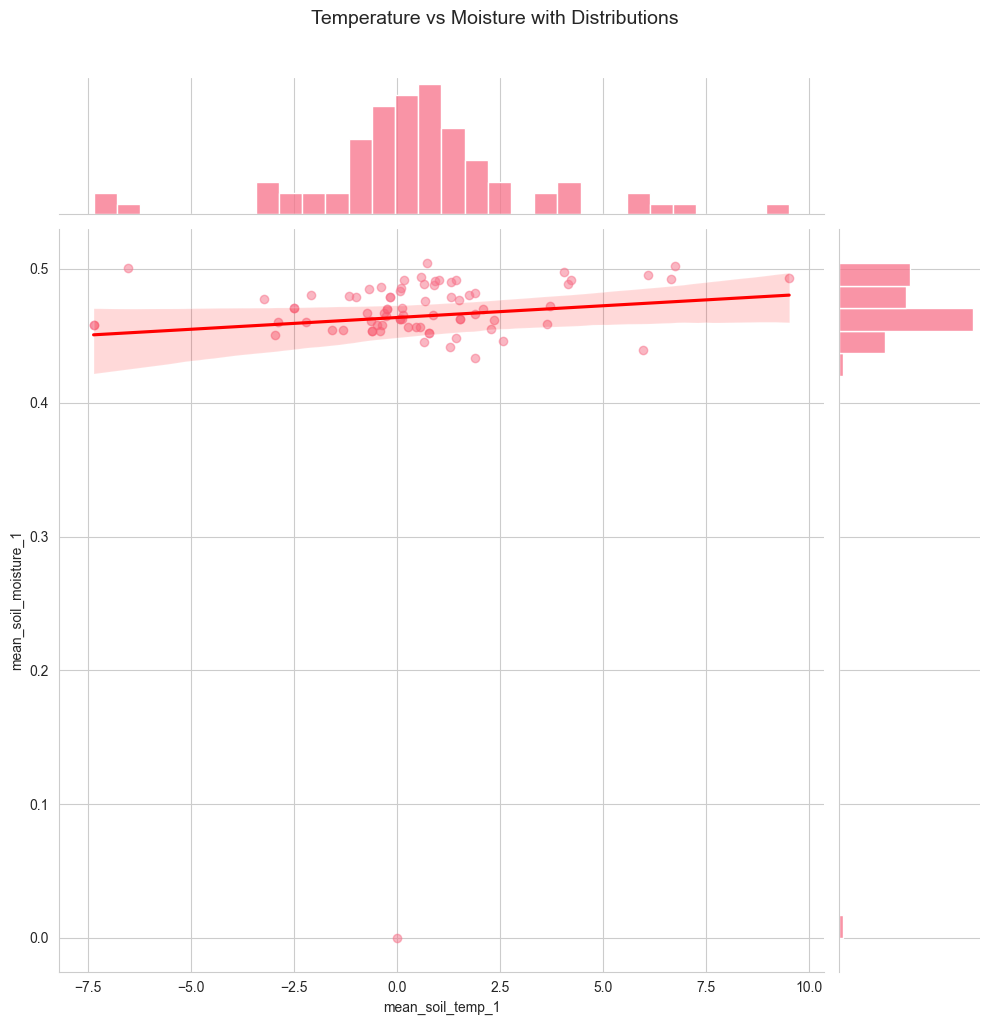

In [39]:
g = sns.JointGrid(data=data, 
                  x=soil_temp_cols[0],
                  y=moisture_cols[0],
                  height=10)
g = g.plot_joint(sns.regplot, 
                 scatter_kws={'alpha':0.5},
                 line_kws={'color': 'red'})
g = g.plot_marginals(sns.histplot, bins=30)
g.fig.suptitle('Temperature vs Moisture with Distributions', y=1.02, fontsize=14)
plt.tight_layout()


This density plot shows how soil temperature and moisture levels are distributed together. The bright yellow area around 0°C and 0.46 moisture indicates where most measurements are found. The colors range from purple (less common) to yellow (most common). There's also a purple spot at -5°C, showing a different group with higher moisture levels.

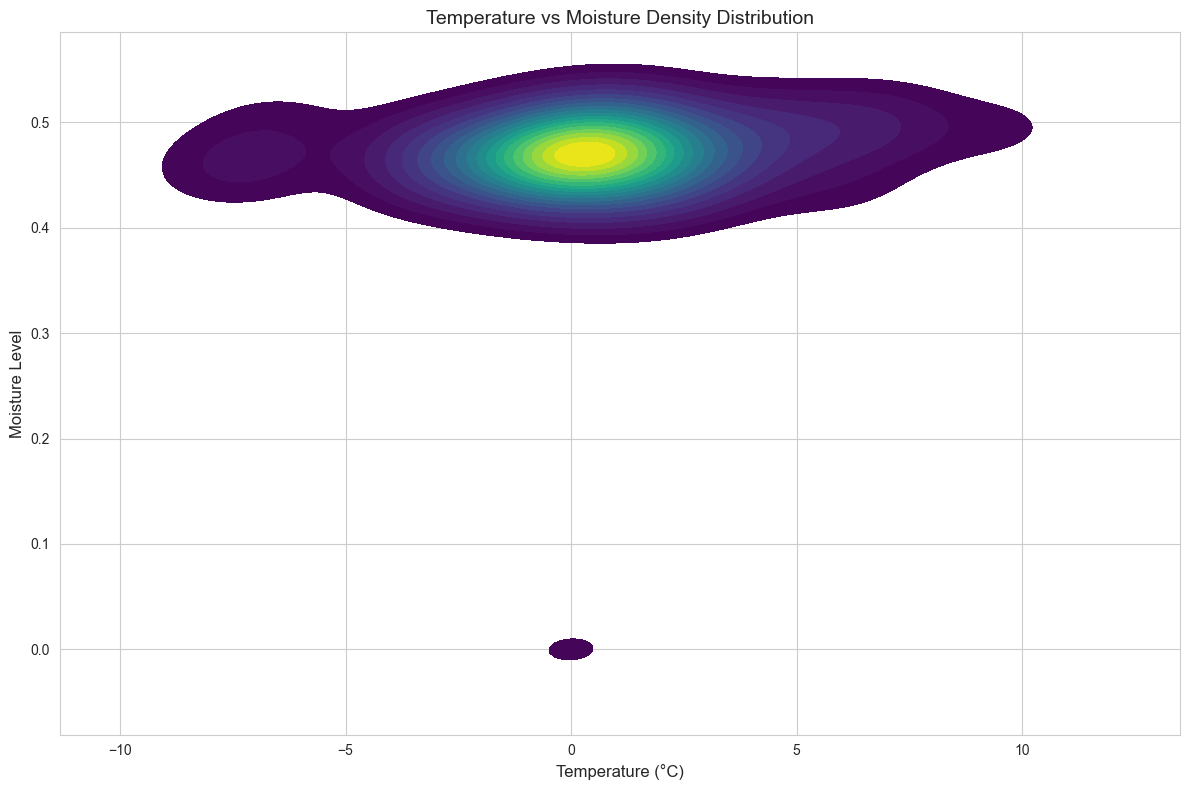

In [40]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data,
            x=soil_temp_cols[0],
            y=moisture_cols[0],
            cmap='viridis',
            fill=True,
            levels=20)
plt.title('Temperature vs Moisture Density Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Moisture Level', fontsize=12)
plt.tight_layout()
plt.show()

#### **Splitting The Data**

In [41]:
def split_data():
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)
    return train_set, test_set

In [42]:
train_set, test_set = split_data()
data = train_set.copy()

# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

- **A.** Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns <mark>✓</mark>
- **B.** Feature selection (optional): Drop attributes that provide no useful information for the task <mark>✓</mark>
- **C.** Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features <mark>✓</mark>
- **D.** Feature scaling: standardize or normalize features <mark>✓</mark>



In [43]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

class TimeSeriesFeatureSelector(BaseEstimator, TransformerMixin):
    """Selects relevant time series features and aggregates them appropriately"""
    def __init__(self, feature_prefix, max_lookback=56):
        self.feature_prefix = feature_prefix
        self.max_lookback = max_lookback
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Select columns that start with the prefix and have numbers up to max_lookback
        cols = [f"{self.feature_prefix}_{i}" for i in range(1, self.max_lookback + 1)]
        cols = [col for col in cols if col in X.columns]
        return X[cols]

class WeatherFeatureAggregator(BaseEstimator, TransformerMixin):
    """Aggregates weather features into summary statistics"""
    def __init__(self, feature_types=['soil_temp', 'soil_moisture', 'temp', 'precipitation', 'snowfall', 'snowdepth']):
        self.feature_types = feature_types
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        result = pd.DataFrame(index=X.index)
        
        for feature in self.feature_types:
            # Find all columns for this feature type
            mean_cols = [col for col in X.columns if col.startswith(f'mean_{feature}')]
            min_cols = [col for col in X.columns if col.startswith(f'min_{feature}')]
            max_cols = [col for col in X.columns if col.startswith(f'max_{feature}')]
            
            if mean_cols:
                result[f'{feature}_mean'] = X[mean_cols].mean(axis=1)
                result[f'{feature}_mean_std'] = X[mean_cols].std(axis=1)
                result[f'{feature}_mean_trend'] = X[mean_cols].diff(axis=1).mean(axis=1)
            
            if min_cols:
                result[f'{feature}_min'] = X[min_cols].min(axis=1)
            
            if max_cols:
                result[f'{feature}_max'] = X[max_cols].max(axis=1)
                
        return result

# Create the preprocessing pipeline
def create_preprocessing_pipeline():
    # Define feature groups
    soil_selector = TimeSeriesFeatureSelector('mean_soil')
    weather_selector = TimeSeriesFeatureSelector('avg_temp')
    precip_selector = TimeSeriesFeatureSelector('precipitation')
    snow_selector = TimeSeriesFeatureSelector('snowfall')
    early_spring_selector = TimeSeriesFeatureSelector('early_spring')
    
    # Create the main pipeline
    preprocessor = Pipeline([
        ('feature_selection', ColumnTransformer([
            ('soil_features', soil_selector, slice(None)),
            ('weather_features', weather_selector, slice(None)),
            ('precipitation_features', precip_selector, slice(None)),
            ('snow_features', snow_selector, slice(None)),
            ('target_features', early_spring_selector, slice(None))
        ])),
        ('aggregator', WeatherFeatureAggregator()),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    return preprocessor

# Function to prepare data and split features/target
def prepare_data(data):
    # Separate target (early spring predictions) from features
    early_spring_cols = [col for col in data.columns if col.startswith('early_spring')]
    target = data[early_spring_cols].iloc[:, 0]  # Use first early spring column as target
    
    # Remove target and prediction columns from features
    feature_data = data.drop(columns=[col for col in data.columns 
                                    if col.startswith(('early_spring', 'prediction'))])
    
    # Create and fit preprocessing pipeline
    preprocessor = create_preprocessing_pipeline()
    X_processed = preprocessor.fit_transform(feature_data)
    
    return X_processed, target, preprocessor

In [44]:
preprocessor = create_preprocessing_pipeline()
preprocessor

Pipeline(steps=[('feature_selection',
                 ColumnTransformer(transformers=[('soil_features',
                                                  TimeSeriesFeatureSelector(feature_prefix='mean_soil'),
                                                  slice(None, None, None)),
                                                 ('weather_features',
                                                  TimeSeriesFeatureSelector(feature_prefix='avg_temp'),
                                                  slice(None, None, None)),
                                                 ('precipitation_features',
                                                  TimeSeriesFeatureSelector(feature_prefix='precipitation'),
                                                  slice(None, None, None)),
                                                 ('snow_features',
                                                  TimeSeriesFeatureSelector(feature_prefix='snowfall'),
                                                  slice(None, None, None)),
                                                 ('target_features',
                                                  TimeSeriesFeatureSelector(feature_prefix='early_spring'),
                                                  slice(None, None, None))])),
                ('aggregator', WeatherFeatureAggregator()),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler())])